In [1]:
!git clone https://github.com/geoindepth/vits-feature-detection.git

Cloning into 'vits-feature-detection'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 17 (delta 4), reused 6 (delta 1), pack-reused 0
Unpacking objects: 100% (17/17), done.


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
plt.rc('figure', figsize=(8, 8))

# Inspect data

In [0]:
# the sample vits pandas dataframe is collected in the file "data/vits-target.gzip".
# you can open it using pd.read_pickle
df = pd.read_pickle('vits-feature-detection/data/vits-target.gzip')

In [5]:
# It is a nested dataframe, every row contain a column target, and the column "vits" pointing to another dataframe object
# you can fetch it using:
vits = df.iloc[0]['vits']
vits.describe()

,nd,gdd
count,23.000000,32.000000
mean,0.447458,11.577867
std,0.159992,7.434767
min,0.244175,0.424125
25%,0.299437,3.788700
50%,0.428047,14.112225
75%,0.600249,18.254569
max,0.696244,20.375475


In [0]:
# some of the vits includes Nan values, if it is a problem you can drop them.

# basically the question is which we can use NN to estimate target using vits.

In [7]:
vits.head()

,date,nd,gdd
0,2017-04-02,NaN,0.424125
1,2017-04-12,NaN,0.593175
2,2017-04-22,NaN,0.617625
3,2017-05-09,NaN,0.832875
4,2017-05-16,NaN,1.374900


In [8]:
df['ratio_nd'] = df.apply(lambda x: x['vits']['nd'].count() / x['vits']['date'].count(), axis=1)
df['ratio_gdd'] = df.apply(lambda x: x['vits']['gdd'].count() / x['vits']['date'].count(), axis=1)
df.describe()

,ratio_nd,ratio_gdd
count,351.000000,351.0
mean,0.989588,1.0
std,0.041443,0.0
min,0.718750,1.0
25%,1.000000,1.0
50%,1.000000,1.0
75%,1.000000,1.0
max,1.000000,1.0


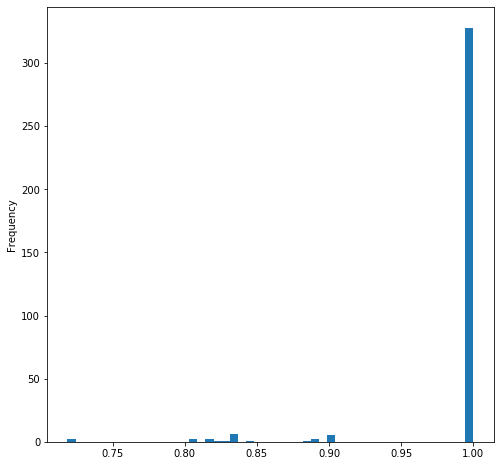

In [9]:
df['ratio_nd'].plot.hist(bins=50);

In [0]:
df['date_min'] = df.apply(lambda x: x['vits']['date'][np.isfinite(x['vits']['nd'])].min(), axis=1)
df['date_max'] = df.apply(lambda x: x['vits']['date'][np.isfinite(x['vits']['nd'])].max(), axis=1)
df['date_range'] = (df['date_max'] - df['date_min']).apply(lambda x: x.days)

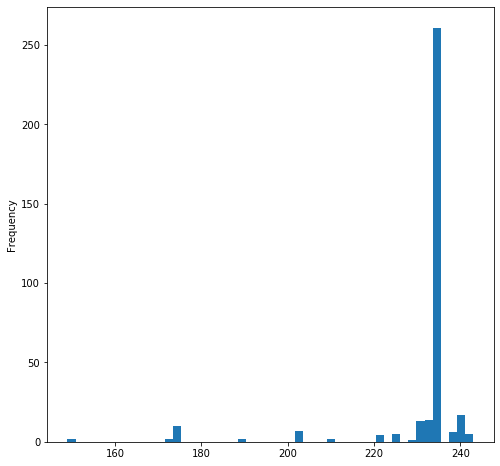

In [11]:
df['date_range'].plot.hist(bins=50);

In [0]:
df['target'] = pd.to_datetime(df['target'])

In [0]:
def plot_vits(idx, ax=None, pred=None, pred_ts=None):
    if ax is None:
        ax = plt
    vits = df['vits'].iloc[idx]
    target = df['target'].iloc[idx]
    ax.plot(vits['date'], vits['nd'], 'o')
    ax.plot(vits['date'], vits['gdd'] / 20, 'o')
    ax.plot([target, target], [0, 1], '-.')
    if pred is not None:
        if isinstance(pred, int):
            pred = pd.DateOffset(pred-1) + pd.datetime(target.year, 1, 1)
        ax.plot([pred, pred], [0, 1], 'r-.')
    if pred_ts is not None:
        x_ts = [pd.DateOffset(d + 75 - 1) + pd.datetime(target.year, 1, 1) 
                for d in range(128, 256)]
        ax.plot(x_ts, np.abs(pred_ts)+0.1, 'r:')

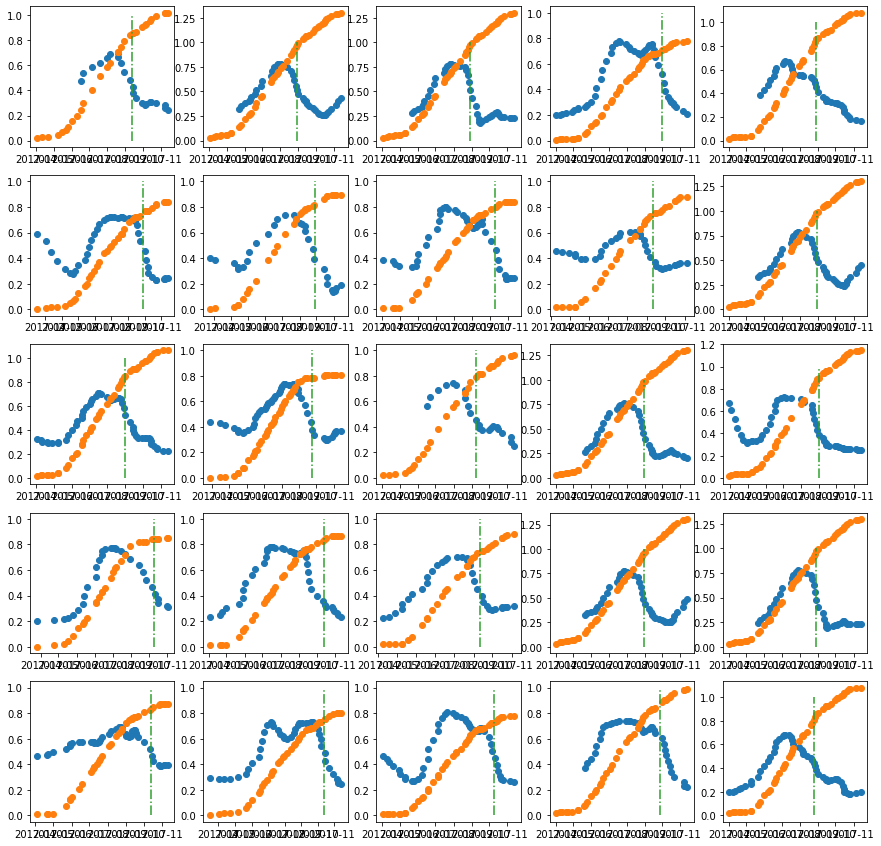

In [14]:
idxs = list(range(25))
fig, ax = plt.subplots(5, 5, figsize=(15, 15))
for i, idx in enumerate(idxs):
    plot_vits(idx, ax.flat[i])

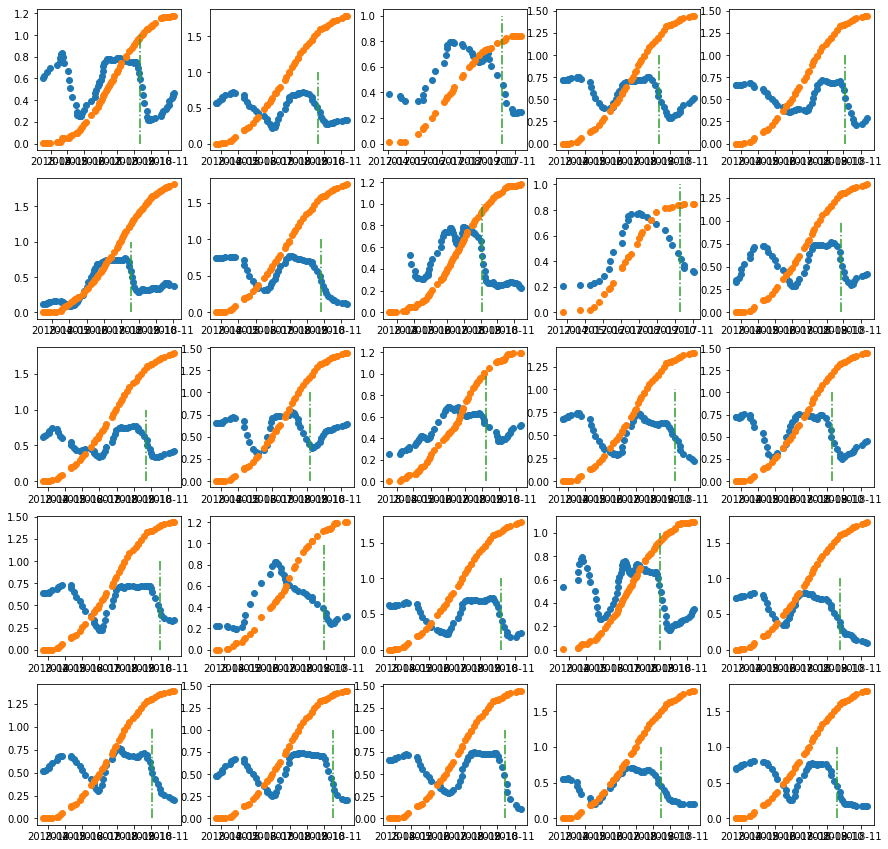

In [15]:
idxs = np.random.choice(df.shape[0], 25, replace=False)
fig, ax = plt.subplots(5, 5, figsize=(15, 15))
for i, idx in enumerate(idxs):
    plot_vits(idx, ax.flat[i])

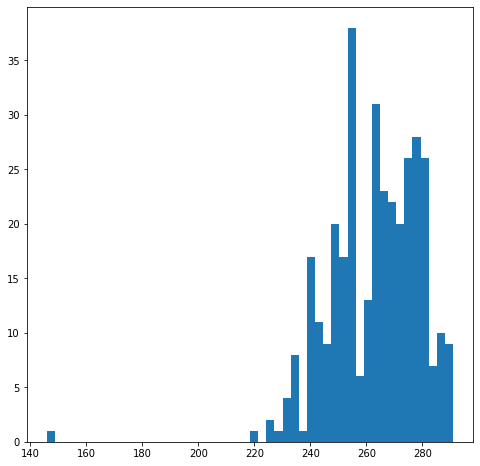

In [16]:
plt.hist(df['target'].dt.dayofyear, bins=50);

In [17]:
df[df['target'].dt.dayofyear < 150]

,target,vits,ratio_nd,ratio_gdd,date_min,date_max,date_range
252,2018-05-26,date nd gdd 0 2018-03-...,1.0,1.0,2018-03-23,2018-11-12,234


In [18]:
df[df['date_range'] < 150]

,target,vits,ratio_nd,ratio_gdd,date_min,date_max,date_range
0,2017-09-12,date nd gdd 0 2017-04-...,0.71875,1.0,2017-06-17,2017-11-13,149
12,2017-09-08,date nd gdd 0 2017-04-...,0.71875,1.0,2017-06-17,2017-11-13,149


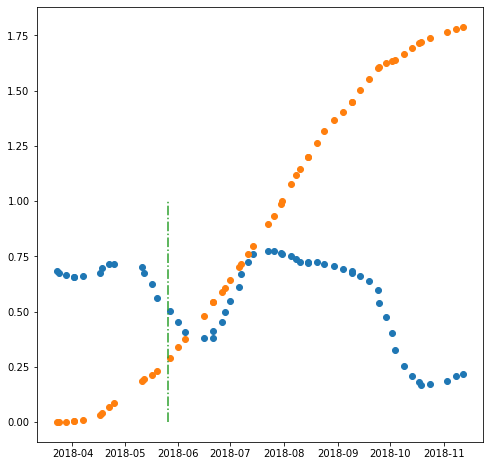

In [19]:
plot_vits(252)

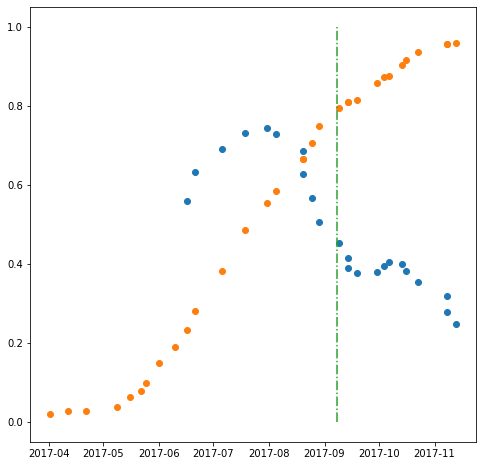

In [20]:
plot_vits(12);

# Input variables

In [21]:
doy_min = df['date_min'].dt.dayofyear.min()
doy_max = df['date_max'].dt.dayofyear.max()
doy_count = int(np.ceil((doy_max - doy_min + 1) / 32) * 32)
doy_min, doy_max, doy_count

(75, 318, 256)

In [22]:
df['target'].dt.dayofyear.min(), df['target'].dt.dayofyear.max()

(146, 291)

In [23]:
y = df['target'].dt.dayofyear - doy_min
z = np.eye(doy_count)[y]
y.shape, z.shape

((351,), (351, 256))

In [0]:
doy_all = np.arange(doy_min, doy_min + doy_count)
list_x = []
for i in range(df.shape[0]):
    vits = df['vits'].iloc[i]
    doy_orig = vits['date'].dt.dayofyear
    indi_valid = np.isfinite(vits['nd'])
    doy_sub = doy_orig[indi_valid]
    arr_nd = np.interp(
        doy_all, doy_sub, vits['nd'][indi_valid],
        left=0, right=0
    )
    arr_gdd = np.interp(
        doy_all, doy_orig, vits['gdd'],
    )
    list_x.append([arr_nd, arr_gdd])

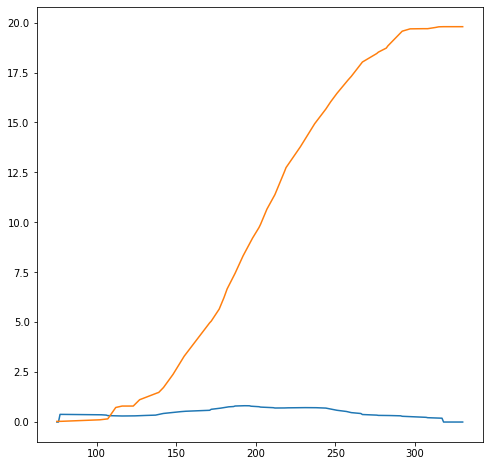

In [25]:
plt.plot(doy_all, arr_nd)
plt.plot(doy_all, arr_gdd);

In [26]:
x = np.array(list_x).transpose((0, 2, 1))
x.min(axis=(0, 1)), x.max(axis=(0, 1))

(array([0., 0.]), array([ 0.85209576, 46.249725  ]))

In [27]:
x[:, :, 1] = x[:, :, 1] / 50
x.shape

(351, 256, 2)

In [28]:
x.min(axis=(0, 1)), x.max(axis=(0, 1))

(array([0., 0.]), array([0.85209576, 0.9249945 ]))

In [0]:
indi_keep = (df.index != 0) & (df.index != 12) & (df.index != 252)
indi_train = indi_keep & (df.index < 250)
indi_val = indi_keep & (df.index >=250) & (df.index < 300)
indi_test = indi_keep & (df.index >= 300)

# Full season

In [29]:
# Run it to obtain reproducible results across machines (from  keras.io)import tensorflow  as tf
import numpy as np
import tensorflow  as tf
import tensorflow.keras as tk
import random as rn
import os

os.environ['PYTHONHASHSEED'] ='0'
np.random.seed(101)
rn.seed(101)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from tensorflow.keras import backend as K

tf.set_random_seed(101)
sess = tf.Session(graph=tf.get_default_graph(),  config=session_conf)
K.set_session(sess)

In [0]:
def Conv1DTranspose(
    input_tensor, 
    filters, kernel_size, 
    strides=2, padding='same', activation=None,
    kernel_initializer=None, name=None,
):
    x = tk.layers.Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
    x = tk.layers.Conv2DTranspose(
        filters=filters, kernel_size=(kernel_size, 1), 
        strides=(strides, 1), padding=padding, activation=activation,
        kernel_initializer=kernel_initializer, name=name,
    )(x)
    x = tk.layers.Lambda(lambda x: K.squeeze(x, axis=2))(x)
    return x

In [0]:
name_model = 'unet_v0'

In [0]:
tk.backend.clear_session()

input_unet = tk.layers.Input(shape=(x.shape[1], x.shape[2]))

conv1 = tk.layers.Conv1D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(input_unet)
conv1 = tk.layers.Conv1D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
pool1 = tk.layers.MaxPooling1D(2)(conv1)

conv2 = tk.layers.Conv1D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
conv2 = tk.layers.Conv1D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
pool2 = tk.layers.MaxPooling1D(2)(conv2)

conv3 = tk.layers.Conv1D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
conv3 = tk.layers.Conv1D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
pool3 = tk.layers.MaxPooling1D(2)(conv3)

conv4 = tk.layers.Conv1D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
conv4 = tk.layers.Conv1D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
pool4 = tk.layers.MaxPooling1D(2)(conv4)

conv5 = tk.layers.Conv1D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
conv5 = tk.layers.Conv1D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
bottleneck = tk.layers.MaxPooling1D(2)(conv5)

decode4 = Conv1DTranspose(
    bottleneck, 32, 3, activation='relu', padding='same', 
    kernel_initializer='he_normal', name='decode4',
)
merge4 = tk.layers.concatenate([pool4, decode4], axis=2, name='merge4')

decode3 = Conv1DTranspose(
    merge4, 16, 3, activation='relu', padding='same', 
    kernel_initializer='he_normal', name='decode3',
)
merge3 = tk.layers.concatenate([pool3, decode3], axis=2, name='merge3')

decode2 = Conv1DTranspose(
    merge3, 8, 3, activation='relu', padding='same', 
    kernel_initializer='he_normal', name='decode2',
)
merge2 = tk.layers.concatenate([pool2, decode2], axis=2, name='merge2')

decode1 = Conv1DTranspose(
    merge2, 8, 3, activation='relu', padding='same', 
    kernel_initializer='he_normal', name='decode1',
)
merge1 = tk.layers.concatenate([pool1, decode1], axis=2, name='merge1')

decode0 = Conv1DTranspose(
    merge1, 4, 3, activation='relu', padding='same', 
    kernel_initializer='he_normal', name='decode0',
)
merge0 = tk.layers.concatenate([input_unet, decode0], name='merge0')

sigmoid = tk.layers.Conv1D(
    1, 3, activation='sigmoid', padding='same', kernel_initializer='he_normal', name='sigmoid',
)(merge0)

output_unet = tk.layers.Flatten()(sigmoid)
model = tk.models.Model(input_unet, output_unet)

In [0]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(lr=5e-4),
    loss=tf.keras.losses.categorical_crossentropy,
)

b_tpu = False

if b_tpu:
    model = tf.contrib.tpu.keras_to_tpu_model(
        model,
        strategy=tf.contrib.tpu.TPUDistributionStrategy(
            tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
        )
    )

early = tk.callbacks.EarlyStopping(monitor='val_loss', patience=10)
save = tk.callbacks.ModelCheckpoint('%s.h5'%name_model, save_best_only=True)
reduce = tk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

hist = model.fit(
    x[indi_train], z[indi_train], batch_size=16, epochs=100, verbose=2, 
    validation_data=(x[indi_val], z[indi_val]), 
    callbacks=[reduce, early, save], shuffle=True
)

if b_tpu:
    model = model.sync_to_cpu()

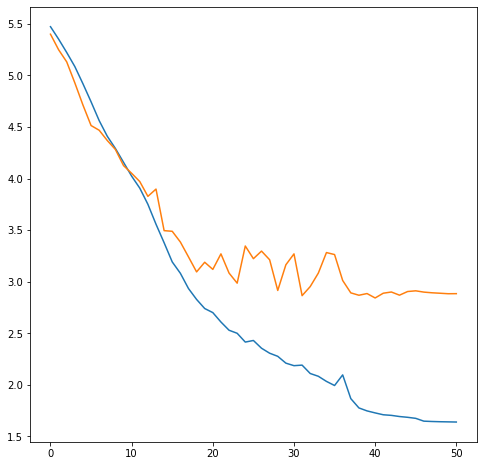

In [0]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
# plt.ylim([0, 0.01])
plt.show()

In [0]:
model = tf.keras.models.load_model(f'{name_model}.h5')
z_pred = model.predict(x)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
y_pred = z_pred.argmax(axis=1) + doy_min

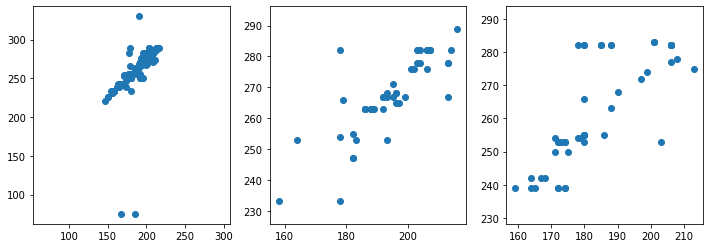

In [0]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
for i, indi in enumerate([indi_train, indi_val, indi_test]):
    ax.flat[i].scatter(y[indi], y_pred[indi])
    ax.flat[i].axis('equal')

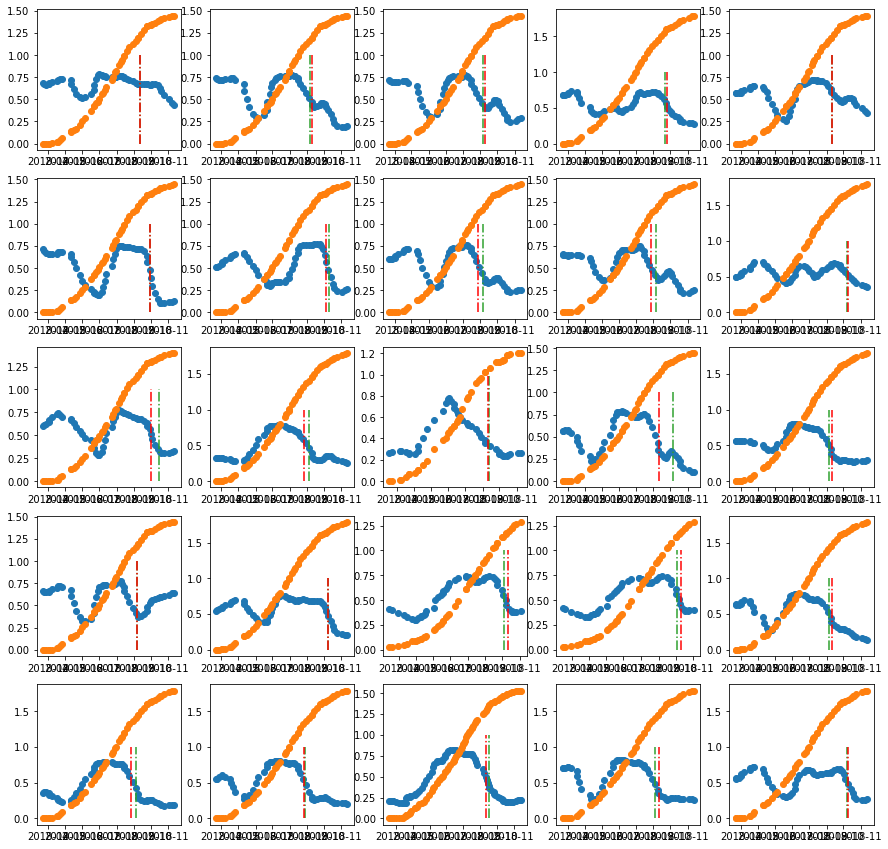

In [0]:
idxs = list(range(300, 325))
fig, ax = plt.subplots(5, 5, figsize=(15, 15))
for i, idx in enumerate(idxs):
    plot_vits(idx, ax.flat[i], pred=int(y_pred[idx]))

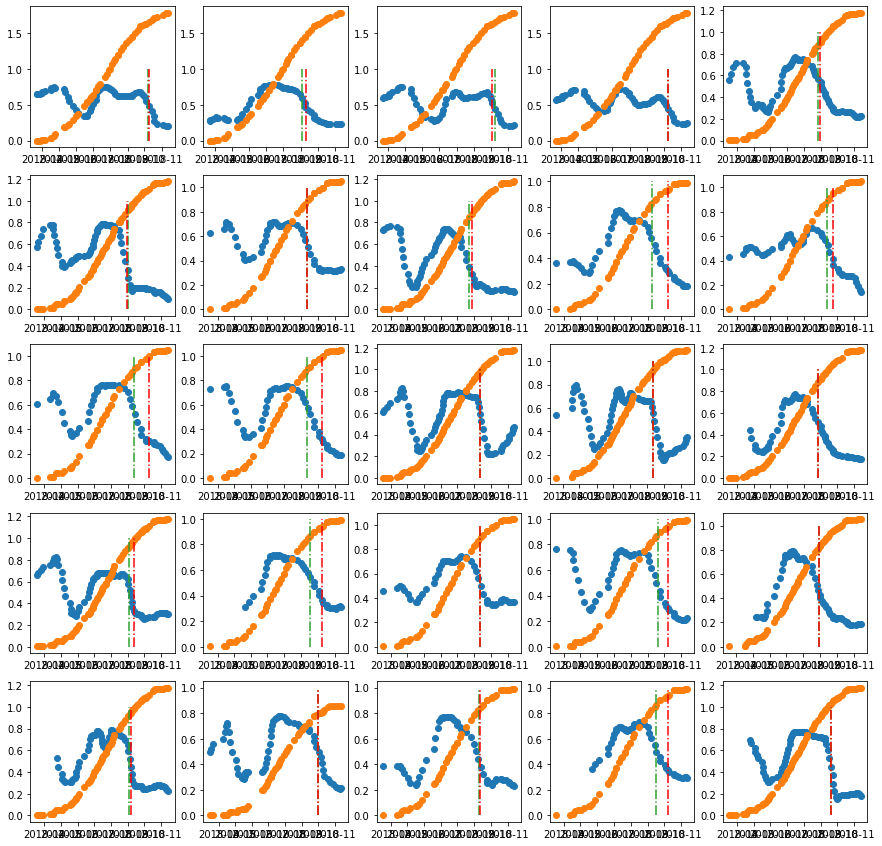

In [0]:
idxs = list(range(325, 350))
fig, ax = plt.subplots(5, 5, figsize=(15, 15))
for i, idx in enumerate(idxs):
    plot_vits(idx, ax.flat[i], pred=int(y_pred[idx]))

# In-season

In [30]:
x.shape

(351, 256, 2)

In [31]:
y.min(), y.max()

(71, 216)

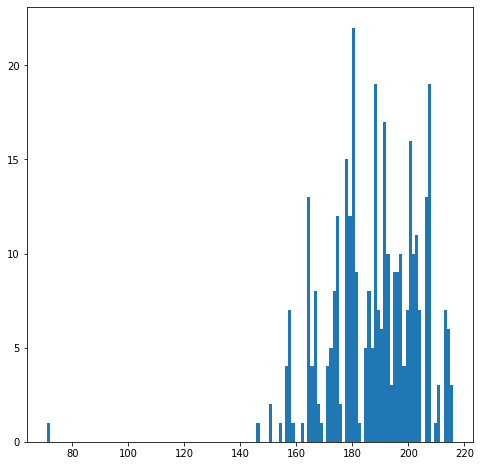

In [32]:
plt.hist(y, bins=128);

In [33]:
list_xt = []
list_yt = []
list_idxt = []
len_t = 128
for i in range(x.shape[0]):
    for j in range(x.shape[1] - len_t):
        list_xt.append(x[i, j:j+len_t])
        list_yt.append(y[i] - j)
        list_idxt.append(i)
xt = np.array(list_xt)
yt = np.array(list_yt)
idxt = np.array(list_idxt)
xt.shape, yt.shape, idxt.shape

((44928, 128, 2), (44928,), (44928,))

-56 216


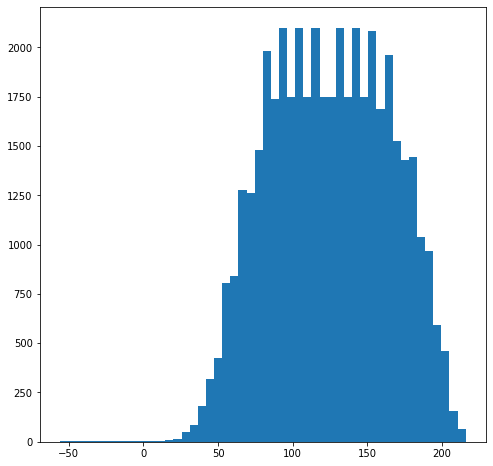

In [34]:
print(yt.min(), yt.max())
plt.hist(yt, bins=50);

In [35]:
zt = (yt - 128) / len_t
zt.min(), zt.max()

(-1.4375, 0.6875)

In [0]:
indi_keep = (idxt != 0) & (idxt != 12) & (idxt != 252)
indi_train = indi_keep & (idxt < 250)
indi_val = indi_keep & (idxt >=250) & (idxt < 300)
indi_test = indi_keep & (idxt >= 300)

In [37]:
zt[indi_keep].min(), zt[indi_keep].max()

(-0.8515625, 0.6875)

In [0]:
name_model = 'lstm_v0'

In [52]:
tk.backend.clear_session()

input_ts = tk.layers.Input(shape=(xt.shape[1], xt.shape[2]))

output = tk.layers.LSTM(32)(input_ts)
output = tk.layers.Dense(1)(output)

model = tk.models.Model(input_ts, output)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [53]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(lr=5e-4),
    loss=tf.keras.losses.mean_absolute_error,
)

early = tk.callbacks.EarlyStopping(monitor='val_loss', patience=10)
save = tk.callbacks.ModelCheckpoint('%s.h5'%name_model, save_best_only=True)
reduce = tk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)

hist = model.fit(
    xt[indi_train], zt[indi_train], batch_size=512, epochs=100, verbose=2, 
    validation_data=(xt[indi_val], zt[indi_val]), 
    callbacks=[reduce, early, save], shuffle=True
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 31744 samples, validate on 6272 samples
Epoch 1/100
31744/31744 - 17s - loss: 0.1696 - val_loss: 0.1083
Epoch 2/100
31744/31744 - 16s - loss: 0.1216 - val_loss: 0.1049
Epoch 3/100
31744/31744 - 16s - loss: 0.1174 - val_loss: 0.1133
Epoch 4/100
31744/31744 - 16s - loss: 0.1106 - val_loss: 0.1259
Epoch 5/100
31744/31744 - 16s - loss: 0.0983 - val_loss: 0.0816
Epoch 6/100
31744/31744 - 16s - loss: 0.0825 - val_loss: 0.0744
Epoch 7/100
31744/31744 - 16s - loss: 0.0747 - val_loss: 0.0693
Epoch 8/100
31744/31744 - 16s - loss: 0.0710 - val_loss: 0.0661
Epoch 9/100
31744/31744 - 16s - loss: 0.0685 - val_loss: 0.0746
Epoch 10/100
31744/31744 - 16s - loss: 0.0664 - val_loss: 0.0821
Epoch 11/100
31744/31744 - 16s - loss: 0.0650 - val_loss: 0.0914
Epoch 12/100
31744/31744 - 16s - loss: 0.0642 - val_loss: 0.0754
Epoch 13/100
31744/31744 - 16s - loss: 0.0636 - val_loss: 0.0726
Epoch 14/100
31744/31

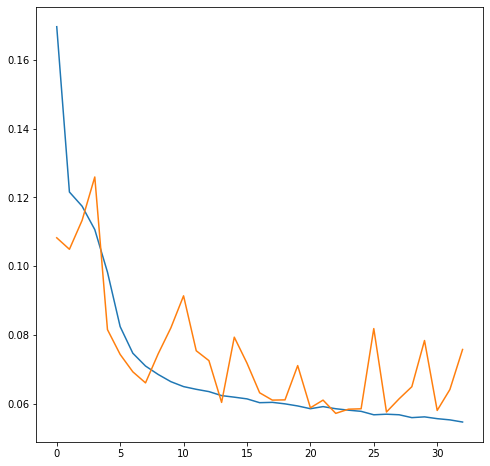

In [54]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
# plt.ylim([0, 0.01])
plt.show()

In [40]:
model = tf.keras.models.load_model(f'{name_model}.h5')
zt_pred = model.predict(xt, batch_size=2048)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [42]:
zt_pred.min(), zt_pred.max()

(-0.6948416, 0.59609807)

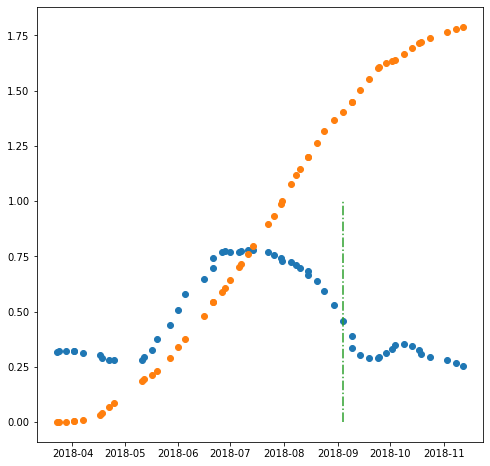

In [43]:
plot_vits(311)

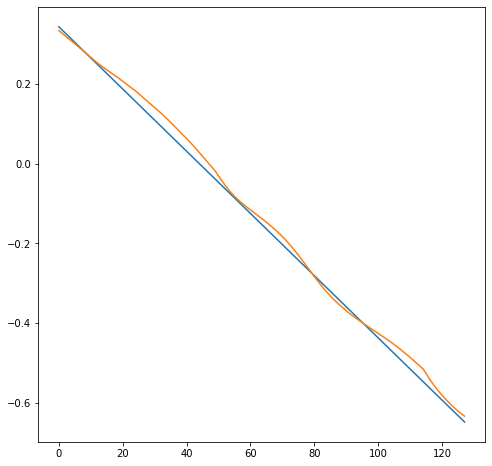

In [44]:
idx = 311
plt.plot(zt[idxt==idx])
plt.plot(zt_pred[idxt==idx, 0]);

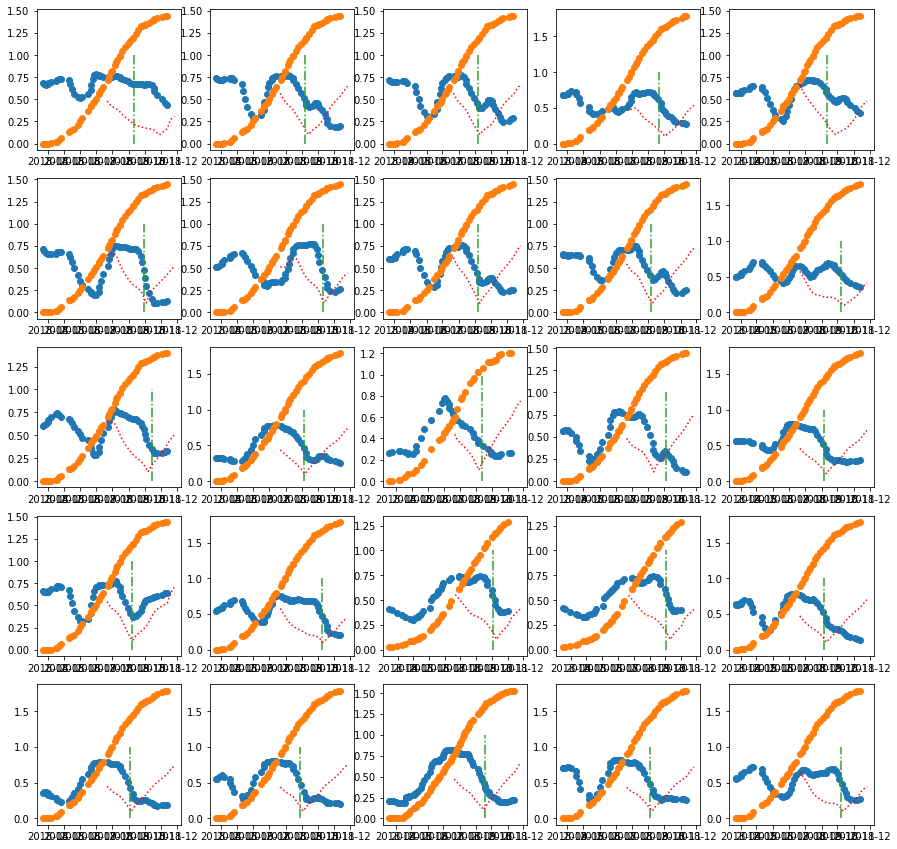

In [64]:
idxs = list(range(300, 325))
fig, ax = plt.subplots(5, 5, figsize=(15, 15))
for i, idx in enumerate(idxs):
    plot_vits(idx, ax.flat[i], pred_ts=zt_pred[idxt==idx])

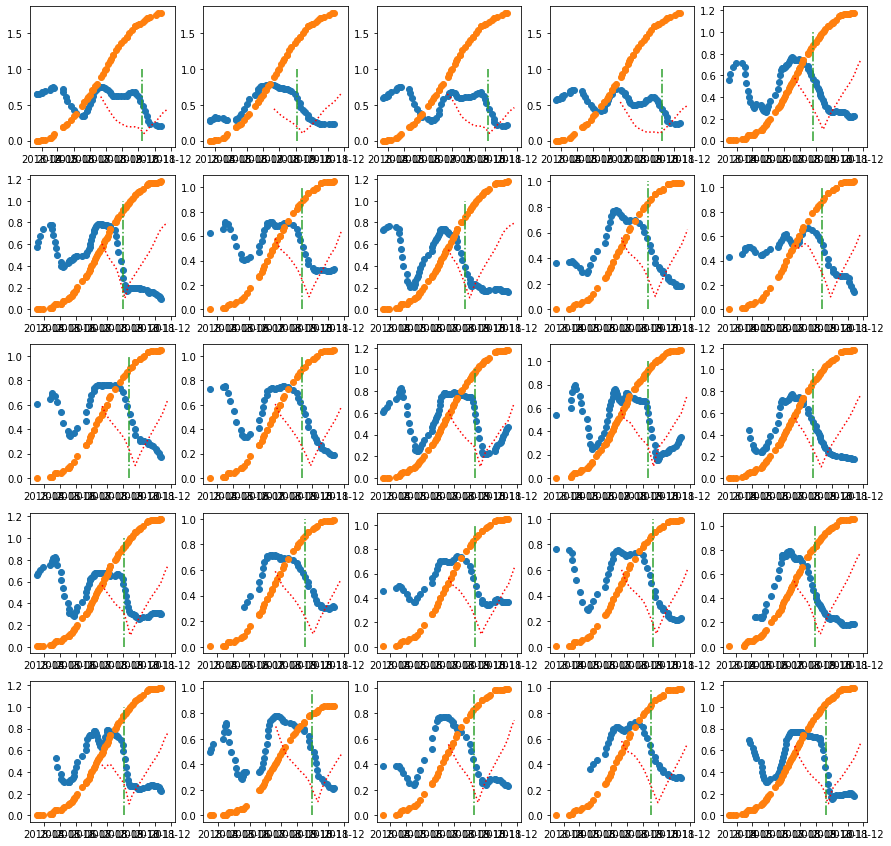

In [62]:
idxs = list(range(325, 350))
fig, ax = plt.subplots(5, 5, figsize=(15, 15))
for i, idx in enumerate(idxs):
    plot_vits(idx, ax.flat[i], pred_ts=zt_pred[idxt==idx])

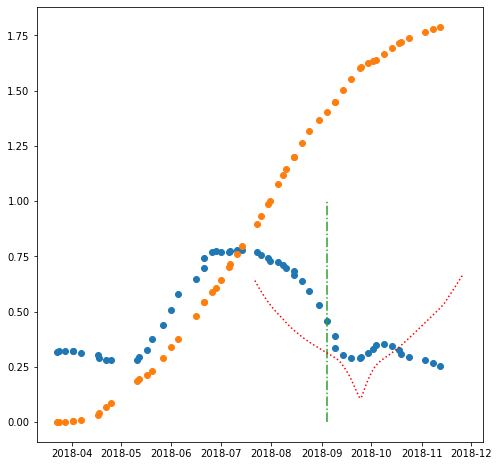

In [63]:
plot_vits(311, pred_ts=zt_pred[idxt==idx])